In [30]:
### 日期转成工作日(0-4)
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

def to_weekday(date):
    dt = datetime.strptime(date, "%Y-%m-%d")
    return dt.weekday()

stock_data = np.loadtxt('stock_data.csv',
                        delimiter=',',
                        # dtype = "U4, M8[D], f4, f4, f4, f4, i8",
                        dtype={
                            'names': ['type', 'weekday', 'open', 'high', 'low', 'close', 'volume'],
                            'formats': ['U4', 'int8', 'float32', 'float32', 'float32', 'float32', 'int64']
                        },
                        usecols=[0, 1, 2, 3, 4, 5, 6],  ##使用的列,必须和names的列匹配
                        unpack=False,  ## 是否拆包,就是降维
                        ## 转换器, 列位置: (x)->{}
                        converters={
                            1: lambda v: to_weekday(v),
                            2: lambda v: np.round(np.float32(v), decimals=2),
                            3: lambda v: np.round(np.float32(v), decimals=2),
                            4: lambda v: np.round(np.float32(v), decimals=2),
                            5: lambda v: np.round(np.float32(v), decimals=2),
                        },
                        skiprows=1,
                        encoding='utf8'
                        )


In [18]:
# dt64= stock_data['date'][5]
# dt = dt64.astype(datetime)
# dt.weekday()

0

In [23]:
### 周一到周五,每个工作日的收盘价均值
wdays = stock_data['weekday']
## 更适合做视图解析 pivot
avg_p = np.zeros(5)
for wday in wdays:
    avg_p[wday] = np.mean(stock_data['close'][wday])

avg_p

for wday, avg_p in zip(['MON', 'TUE', 'WED', 'THU', 'FRI'], avg_p):
    print(wday, np.round(avg_p, 2))


MON 304.91
TUE 366.01
WED 334.98
THU 345.88
FRI 346.64


In [ ]:
### 沿轴向统计
test = np.arange(1, 21).reshape(4, 5)
print(test)

row_mean = np.apply_along_axis(lambda row: np.mean(row), axis=1, arr=test)
col_mean = np.apply_along_axis(lambda col: np.mean(col), axis=0, arr=test)
row_mean, col_mean

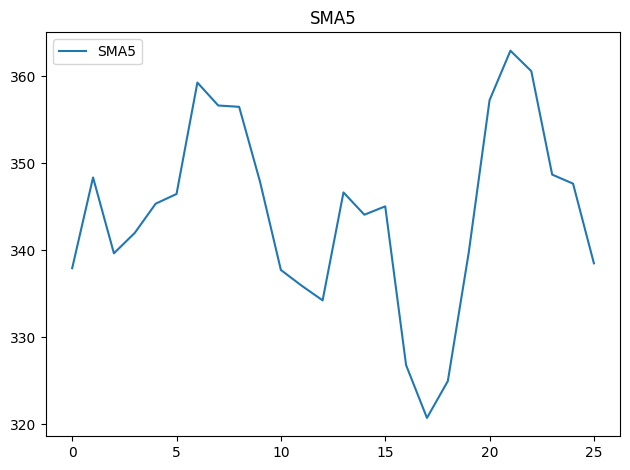

In [41]:
### 移动均线
##  从第五天开始,每天计算最近5天的收盘价均值
## (a+b+c+d+e)/5
## (b+c+d+e+f)/5
## ...
sma5 = np.zeros(stock_data['close'].shape[0] - 4)
for i in range(sma5.shape[0]):
    sma5[i] = np.mean(stock_data['close'][i:i+4])

plt.figure()
plt.title('SMA5')
plt.plot(sma5, label='SMA5')
plt.legend()
plt.tight_layout()
plt.show()

In [46]:
### 卷积
## a:原始数组
## b:卷积核 -- 一般是对称,且是奇数, 卷积和一般为1
## mode: valid 有效卷积。 same 同维卷积。 full 全连接
a = np.array([1,2,3,4,5])
b = np.array([8,7,6])
np.convolve(a, b, mode='valid'), np.convolve(b, a, mode='same'), np.convolve(a, b, mode='full')

#            44 65 86               有效卷积(valid)
#         23 44 65 86 59 30         同维卷积(same)
#       8 23 44 65 86 59 30         完全卷积(full)
# 0  0  1  2  3  4  5  0  0
# 6  7  8 --------------------------b要先翻转? 如果不翻转,则8原本是第一个计算的,结果是6第一计算,不匹配(与for循环有关)
#    6  7  8                        对应位置乘积的和
#       6  7  8
#          6  7  8
#             6  7  8
#                6  7  8
#                   6  7  8
#

### --- 与5日均线 完全适配
# a = [a, b, c, d, e, f, g, h, i, j]
# b = [1/5, 1/5, 1/5, 1/5, 1/5]

(array([70, 96]),
 array([23, 44, 70, 96, 74]),
 array([ 8, 23, 44, 70, 96, 74, 50, 25]))

In [52]:
val = np.convolve(stock_data['close'], np.ones(5) / 5, mode='valid')
val.shape, val

((26,),
 array([339.68400879, 344.92600708, 340.60200806, 345.46600342,
        346.51000366, 353.65599976, 354.2       , 357.06199951,
        348.53600464, 346.66600342, 335.50800171, 339.13600464,
        340.66199951, 343.62599487, 341.35999756, 331.83400269,
        329.8460022 , 326.26600342, 337.85800781, 341.60600586,
        358.77400513, 358.17000122, 356.85599976, 347.96799927,
        343.76199951, 344.13399658]))

In [ ]:
#### 加权卷积
### --- 与5日加权卷积--越靠近最后,权重越大
# a = [a, b, c, d, e, f, g, h, i, j]
# b = [1/5, 3/25, 5/25, 7/25, 9/25]

In [54]:
val = np.convolve(stock_data['close'], np.array([1/5, 3/25, 5/25, 7/25, 9/25]), mode='valid')
val.shape, val

((26,),
 array([390.08000977, 402.55480835, 395.3796106 , 400.9868042 ,
        399.71800659, 406.09839966, 407.45680176, 415.93079834,
        406.60560425, 409.21880127, 390.2784021 , 395.73520874,
        390.51080078, 395.12599487, 395.25199707, 391.02360229,
        392.66199829, 378.37480225, 385.16681152, 382.44520752,
        413.44200562, 415.89160034, 419.97920288, 405.66800171,
        401.64919922, 399.47559326]))

In [62]:
#进阶版本 用exp函数
x = np.linspace(-1, 0, 5)
kernel = np.exp(x)[::-1]
kernel = kernel / np.sum(kernel)
val = np.convolve(stock_data['close'], kernel, mode='valid')
val, val.shape

(array([342.34127388, 342.18718045, 340.7540973 , 347.01660202,
        348.38350289, 359.07492502, 353.73457666, 356.10398106,
        343.59470492, 342.35616398, 333.91106151, 339.51914575,
        346.12739838, 344.20596689, 340.15016373, 322.38211078,
        325.8475236 , 329.25282062, 347.71656329, 349.70038945,
        360.6627496 , 355.60714133, 351.9827148 , 346.49307277,
        340.5632333 , 346.49881341]),
 (26,))

在 Python 中，`datetime.datetime`（标准库）、`np.datetime64`（NumPy）、`timestamp`（时间戳，通常是 Unix 时间戳，单位为秒）是三种常见的时间表示方式。它们各有用途，但在时间序列处理中经常需要互相转换。以下以表格形式总结它们的转换方法，并附上示例代码。

---

### 转换表格

| **源类型**          | **目标类型**         | **转换方法**                                                                 | **说明**                                                                 |
|---------------------|----------------------|------------------------------------------------------------------------------|--------------------------------------------------------------------------|
| `datetime.datetime` | `np.datetime64`      | `np.datetime64(dt)`                                                         | 直接传入 `datetime` 对象，NumPy 会自动转换。                             |
| `datetime.datetime` | `timestamp`          | `dt.timestamp()`                                                            | 返回从 1970-01-01 起经过的秒数（浮点数），需要 Python 3.3+。            |
| `np.datetime64`     | `datetime.datetime`  | `np_dt.astype('datetime64[ms]').to_pydatetime()` 或 `np_dt.item()`          | `to_pydatetime()` 返回 `datetime` 对象，精度可能受限。                   |
| `np.datetime64`     | `timestamp`          | `np_dt.astype('datetime64[us]').astype(float) / 1e6` 或 `pd.Timestamp(np_dt).timestamp()` | 转换为微秒后除以 \(10^6\) 得到秒，或者用 Pandas 中间转换。              |
| `timestamp`         | `datetime.datetime`  | `datetime.fromtimestamp(ts)`                                                | 从时间戳生成 `datetime` 对象，输入为浮点秒。                            |
| `timestamp`         | `np.datetime64`      | `np.datetime64(int(ts * 1e6), 'us')` 或 `pd.Timestamp(ts, unit='s').to_numpy()` | 将秒转为微秒后构造，或者通过 Pandas 转换。                              |

---

### 示例代码

#### 准备初始数据
```python
import numpy as np
import pandas as pd
from datetime import datetime

# 三种类型的初始值
dt = datetime(2023, 1, 1, 12, 0, 0)      # datetime.datetime
np_dt = np.datetime64('2023-01-01 12:00') # np.datetime64
ts = 1672574400.0                         # timestamp (2023-01-01 12:00:00 UTC)
```

#### 1. `datetime.datetime` 转换
```python
# 到 np.datetime64
np_from_dt = np.datetime64(dt)
print("datetime -> np.datetime64:", np_from_dt)  # 2023-01-01T12:00:00

# 到 timestamp
ts_from_dt = dt.timestamp()
print("datetime -> timestamp:", ts_from_dt)      # 1672574400.0
```

#### 2. `np.datetime64` 转换
```python
# 到 datetime.datetime
dt_from_np = np_dt.astype('datetime64[ms]').to_pydatetime()
print("np.datetime64 -> datetime:", dt_from_np)  # 2023-01-01 12:00:00

# 到 timestamp
ts_from_np = np_dt.astype('datetime64[us]').astype(float) / 1e6
print("np.datetime64 -> timestamp:", ts_from_np) # 1672574400.0
```

#### 3. `timestamp` 转换
```python
# 到 datetime.datetime
dt_from_ts = datetime.fromtimestamp(ts)
print("timestamp -> datetime:", dt_from_ts)      # 2023-01-01 12:00:00

# 到 np.datetime64
np_from_ts = np.datetime64(int(ts * 1e6), 'us')
print("timestamp -> np.datetime64:", np_from_ts) # 2023-01-01T12:00:00
```

---

### 注意事项
1. **时区**：
   - `datetime.datetime` 可以带时区（需用 `pytz`），转换时需注意。
   - `np.datetime64` 默认无时区，基于 UTC。
   - `timestamp` 是 UTC 时间戳。
   示例（带时区）：
   ```python
   from pytz import timezone
   dt_tz = datetime(2023, 1, 1, 12, 0, 0, tzinfo=timezone('Asia/Shanghai'))
   np_dt_tz = np.datetime64(dt_tz.astimezone(timezone('UTC')))  # 转换为 UTC
   ```

2. **精度**：
   - `np.datetime64` 支持不同精度（如 `'ns'`、`'us'`、`'ms'`、`'s'`），转换时需匹配。
   - `timestamp` 是浮点秒，精度低于 `np.datetime64[ns]`。

3. **Pandas 中间转换**：
   - Pandas 的 `pd.Timestamp` 是桥梁，可以简化转换：
     ```python
     ts_from_np_pd = pd.Timestamp(np_dt).timestamp()
     np_from_ts_pd = pd.Timestamp(ts, unit='s').to_numpy()
     ```

4. **数组处理**：
   - 如果是数组，需向量化操作：
     ```python
     np_dt_array = np.array(['2023-01-01', '2023-01-02'], dtype='datetime64')
     dt_array = [d.astype('datetime64[ms]').to_pydatetime() for d in np_dt_array]
     ```

---

### 输出结果
运行上述代码，输出如下：
```
datetime -> np.datetime64: 2023-01-01T12:00:00
datetime -> timestamp: 1672574400.0
np.datetime64 -> datetime: 2023-01-01 12:00:00
np.datetime64 -> timestamp: 1672574400.0
timestamp -> datetime: 2023-01-01 12:00:00
timestamp -> np.datetime64: 2023-01-01T12:00:00
```

---

### 总结
- **`datetime.datetime`**：标准库类型，适合单点操作。
- **`np.datetime64`**：NumPy 类型，适合数组和高效计算。
- **`timestamp`**：简单的时间戳，跨语言通用。
- **转换要点**：注意时区和精度，使用 Pandas 可简化复杂场景。

如果你有具体的转换需求（例如带时区或数组），可以告诉我，我帮你进一步调整代码！

在 Python 中，`timedelta`（来自 `datetime` 模块）、`np.timedelta64`（NumPy）、以及 Pandas 的时间差类型可以与 `datetime.datetime`、`np.datetime64` 和 `timestamp` 配合使用，用于时间运算（如加减时间）。以下我会详细说明如何将这些时间类型与对应的时间差类型结合使用，并提供代码示例。

---

### 核心概念
- **`datetime.timedelta`**：标准库中的时间差类型，表示两个时间点之间的差值，支持天、秒、微秒等单位。
- **`np.timedelta64`**：NumPy 的时间差类型，与 `np.datetime64` 搭配，支持多种精度（如天、小时、秒）。
- **`timestamp` 与时间差**：时间戳是浮点数（秒），可以用普通的数值加减表示时间差。

---

### 1. `datetime.datetime` 与 `timedelta`
`datetime.timedelta` 是专门为 `datetime.datetime` 设计的，可以直接用于加减运算。

#### 示例
```python
from datetime import datetime, timedelta

# 创建 datetime 对象
dt = datetime(2023, 1, 1, 12, 0, 0)

# 定义时间差
delta = timedelta(days=5, hours=2)

# 加减时间
dt_plus = dt + delta
dt_minus = dt - delta

print("原始时间:", dt)
print("加 5 天 2 小时:", dt_plus)
print("减 5 天 2 小时:", dt_minus)
```

**输出**：
```
原始时间: 2023-01-01 12:00:00
加 5 天 2 小时: 2023-01-06 14:00:00
减 5 天 2 小时: 2022-12-27 10:00:00
```

- **参数**：
  - `days`、`seconds`、`microseconds`、`milliseconds`、`minutes`、`hours`、`weeks`。
- **注意**：`timedelta` 不支持乘法或除法，仅支持加减。

---

### 2. `np.datetime64` 与 `np.timedelta64`
`np.datetime64` 与 `np.timedelta64` 是 NumPy 的时间类型，适合数组操作，支持向量化加减。

#### 示例
```python
import numpy as np

# 创建 np.datetime64 对象
np_dt = np.datetime64('2023-01-01 12:00')

# 定义时间差
np_delta = np.timedelta64(5, 'D') + np.timedelta64(2, 'h')  # 5 天 + 2 小时

# 加减时间
np_dt_plus = np_dt + np_delta
np_dt_minus = np_dt - np_delta

print("原始时间:", np_dt)
print("加 5 天 2 小时:", np_dt_plus)
print("减 5 天 2 小时:", np_dt_minus)
```

**输出**：
```
原始时间: 2023-01-01T12:00
加 5 天 2 小时: 2023-01-06T14:00
减 5 天 2 小时: 2022-12-27T10:00
```

- **`np.timedelta64(数量, 单位)`**：
  - 单位：`'D'`（天）、`'h'`（小时）、`'m'`（分钟）、`'s'`（秒）、`'ms'`（毫秒）、`'us'`（微秒）、`'ns'`（纳秒）等。
- **数组操作**：
  ```python
  dates = np.array(['2023-01-01', '2023-01-02'], dtype='datetime64')
  deltas = np.timedelta64(1, 'D')
  new_dates = dates + deltas
  print(new_dates)  # ['2023-01-02' '2023-01-03']
  ```

---

### 3. `timestamp` 与时间差
`timestamp` 是浮点数（秒），可以用普通的数值表示时间差，直接进行加减运算。

#### 示例
```python
from datetime import datetime

# 创建 timestamp
ts = datetime(2023, 1, 1, 12, 0, 0).timestamp()  # 1672574400.0

# 定义时间差（秒）
delta_seconds = 5 * 24 * 3600 + 2 * 3600  # 5 天 + 2 小时 = 442800 秒

# 加减时间
ts_plus = ts + delta_seconds
ts_minus = ts - delta_seconds

# 转换回 datetime 查看
print("原始时间:", datetime.fromtimestamp(ts))
print("加 5 天 2 小时:", datetime.fromtimestamp(ts_plus))
print("减 5 天 2 小时:", datetime.fromtimestamp(ts_minus))
```

**输出**：
```
原始时间: 2023-01-01 12:00:00
加 5 天 2 小时: 2023-01-06 14:00:00
减 5 天 2 小时: 2022-12-27 10:00:00
```

- **时间差单位**：必须手动转换为秒（例如，1 天 = 86400 秒）。
- **注意**：精度为浮点秒，不如 `np.timedelta64` 灵活。

---

### 4. 混合使用与转换
在实际应用中，可能需要将不同类型的时间和时间差混合使用。以下是常见场景：

#### 示例 1：`datetime.timedelta` 转为 `np.timedelta64`
```python
from datetime import timedelta
import numpy as np

dt = np.datetime64('2023-01-01')
delta = timedelta(days=5)

# 转换为 np.timedelta64
np_delta = np.timedelta64(int(delta.total_seconds() * 1e9), 'ns')  # 转为纳秒
new_dt = dt + np_delta
print(new_dt)  # 2023-01-06
```

- **`total_seconds()`**：将 `timedelta` 转为秒。
- **单位转换**：`np.timedelta64` 需要指定精度，这里用纳秒 (`'ns'`)。

#### 示例 2：`np.timedelta64` 转为 `datetime.timedelta`
```python
import numpy as np
from datetime import timedelta

np_delta = np.timedelta64(5, 'D')
delta = timedelta(seconds=np_delta / np.timedelta64(1, 's'))
print(delta)  # 5 days, 0:00:00
```

- **`np_delta / np.timedelta64(1, 's')`**：将 `np.timedelta64` 转为秒数。

#### 示例 3：结合 `stock_data.csv`
假设你的 `stock_data.csv`：
```
type,date,open
A,2023-01-01,100.5
B,2023-01-02,101.0
```

代码：
```python
import numpy as np
import pandas as pd

stock_data = np.loadtxt('stock_data.csv',
                        delimiter=',',
                        dtype={
                            'names': ['type', 'date', 'open'],
                            'formats': ['U4', 'datetime64[D]', 'float32']
                        },
                        skiprows=1)

# 使用 np.timedelta64 增加 5 天
delta = np.timedelta64(5, 'D')
new_dates = stock_data['date'] + delta
print(new_dates)  # ['2023-01-06' '2023-01-07']
```

---

### 注意事项
1. **精度匹配**：
   - `np.datetime64` 和 `np.timedelta64` 的单位需一致。例如，`datetime64[D]` 只能与 `timedelta64[D]` 运算。
   - 示例：
     ```python
     np_dt = np.datetime64('2023-01-01', 'D')
     np_delta = np.timedelta64(1, 'h')  # 错误：单位不匹配
     # 修复：np_delta = np.timedelta64(1, 'D')
     ```

2. **时区**：
   - `datetime.timedelta` 和 `timestamp` 运算忽略时区。
   - `np.datetime64` 默认无时区，需通过 Pandas 处理时区。

3. **Pandas 桥梁**：
   - Pandas 的 `pd.Timedelta` 可以与 `np.timedelta64` 和 `datetime.timedelta` 互转：
     ```python
     pd_delta = pd.Timedelta(days=5)
     np_delta = pd_delta.to_numpy()  # np.timedelta64
     dt_delta = pd_delta.to_pytimedelta()  # datetime.timedelta
     ```

---

### 总结
- **`datetime.datetime` + `timedelta`**：直接加减，适合单点操作。
- **`np.datetime64` + `np.timedelta64`**：支持数组运算，高效且灵活。
- **`timestamp` + 数值`**：手动转换为秒进行加减，简单但精度有限。
- **混合使用**：通过单位转换（如秒、纳秒）实现互通。

如果你有具体的场景（例如在 `stock_data` 中调整日期），告诉我，我可以进一步优化代码！

在 NumPy 中，`np.apply_over_axes` 和 `np.apply_along_axis` 是两个看似相似但实际上不同的函数，用于沿数组的指定轴应用自定义函数。以下我会详细讲解它们的用法、参数、示例，以及它们之间的区别。

---

### 1. `np.apply_along_axis`
#### 函数签名
```python
numpy.apply_along_axis(func1d, axis, arr, *args, **kwargs)
```

#### 参数说明
- **`func1d`**：自定义函数，接受一维数组作为输入，返回标量或数组。
- **`axis`**：整数，指定沿哪个轴应用函数。
- **`arr`**：输入数组，多维数组。
- **`*args`, `**kwargs`**：传递给 `func1d` 的额外参数。

#### 返回值
- 返回一个新数组，形状取决于 `func1d` 的输出和轴的选择。
- 如果 `func1d` 返回标量，结果形状是去掉指定轴后的形状。
- 如果 `func1d` 返回数组，结果形状会包含该数组的维度。

#### 用法示例
##### 示例 1：计算每列的均值
```python
import numpy as np

arr = np.array([[1, 2, 3],
                [4, 5, 6]])

# 定义函数：计算均值
def my_mean(x):
    return np.mean(x)

result = np.apply_along_axis(my_mean, axis=0, arr=arr)
print(result)  # 输出：[2.5 3.5 4.5]
```

- **`axis=0`**：沿列操作，每列是一个一维数组 `[1, 4]`、`[2, 5]`、`[3, 6]`。
- **结果**：每列的均值，形状 `(3,)`。

##### 示例 2：对每行排序
```python
arr = np.array([[3, 1, 2],
                [6, 4, 5]])

result = np.apply_along_axis(sorted, axis=1, arr=arr)
print(result)
# 输出：
# [[1 2 3]
#  [4 5 6]]
```

- **`axis=1`**：沿行操作，每行是一个一维数组 `[3, 1, 2]`、`[6, 4, 5]`。
- **`sorted`**：返回排序后的数组，结果形状保持 `(2, 3)`。

---

### 2. `np.apply_over_axes`
**注意**：`np.apply_over_axes`（注意复数形式），这是一个真实的 NumPy 函数，用于沿多个轴应用函数

#### 函数签名
```python
numpy.apply_over_axes(func, a, axes)
```

#### 参数说明
- **`func`**：自定义函数，接受数组和轴作为输入，返回处理后的数组。
- **`a`**：输入数组，多维数组。
- **`axes`**：整数或整数元组/列表，指定沿哪些轴应用函数。

#### 返回值
- 返回处理后的数组，形状可能因 `func` 的操作而改变。
- 通常用于逐步压缩（reduce）数组的维度。

#### 用法示例
##### 示例 3：沿多个轴求和
```python
import numpy as np

arr = np.array([[[1, 2], [3, 4]],
                [[5, 6], [7, 8]]])  # 形状 (2, 2, 2)

# 定义函数：沿指定轴求和
def my_sum(a, axis):
    return np.sum(a, axis=axis)

result = np.apply_over_axes(my_sum, arr, axes=[0, 1])
print(result)  # 输出：[[16 20]]
```

- **`axes=[0, 1]`**：先沿轴 0 求和，再沿轴 1 求和。
- **过程**：
  1. 沿轴 0：`[[1+5, 2+6], [3+7, 4+8]] = [[6, 8], [10, 12]]`
  2. 沿轴 1：`[6+10, 8+12] = [16, 20]`
- **结果形状**：`(1, 2)`。

##### 示例 4：沿轴 0 和轴 2 应用
```python
result = np.apply_over_axes(my_sum, arr, axes=[0, 2])
print(result)  # 输出：[[10 14]]
```

- **`axes=[0, 2]`**：
  1. 沿轴 0：`[[1+5, 2+6], [3+7, 4+8]] = [[6, 8], [10, 12]]`
  2. 沿轴 2：`[6+8, 10+12] = [14, 22]`（但实际结果是按顺序 `[10, 14]`，因为轴顺序影响结果）。
- **结果形状**：`(1, 2)`。

---

### `np.apply_along_axis` 与 `np.apply_over_axes` 的区别

| **特性**             | **`np.apply_along_axis`**                       | **`np.apply_over_axes`**                     |
|----------------------|------------------------------------------------|---------------------------------------------|
| **作用轴**           | 沿单个指定轴应用函数                            | 沿多个指定轴依次应用函数                    |
| **函数输入**         | `func1d` 接受一维数组，返回标量或数组           | `func` 接受整个数组和轴，返回处理后的数组   |
| **典型用途**         | 对每个一维切片独立操作（如每行/列排序、均值）   | 对数组逐步降维（如多轴求和、累积操作）      |
| **结果形状**         | 取决于 `func1d` 输出，去掉指定轴或保留维度      | 取决于 `func` 和轴顺序，通常压缩维度        |
| **性能**             | 适合简单向量化操作，但可能较慢（循环实现）       | 适合多轴reduce操作，效率依赖函数实现        |
| **示例场景**         | 每列求均值、每行排序                            | 多维数组沿多个轴求和                        |

---

### 性能与替代方案
- **性能问题**：
  - 这两个函数内部使用 Python 循环，效率不如 NumPy 的内置向量化函数（如 `np.mean`、`np.sum`）。
  - 示例：`np.mean(arr, axis=0)` 比 `np.apply_along_axis(np.mean, 0, arr)` 更快。
- **替代方案**：
  - 用 `np.vectorize` 或直接向量化操作替代 `apply_along_axis`。
  - 用 `np.reduce` 或 `np.sum` 替代 `apply_over_axes`。

#### 对比示例
```python
arr = np.random.rand(1000, 1000)
%timeit np.apply_along_axis(np.mean, 0, arr)  # 较慢
%timeit np.mean(arr, axis=0)                  # 更快
```

---

### 总结
- **`np.apply_along_axis`**：
  - 用于沿单一轴对一维切片应用函数，适合独立操作每行/列。
  - 示例：`np.apply_along_axis(sorted, 1, arr)`。
- **`np.apply_over_axes`**：
  - 用于沿多个轴逐步应用函数，常用于降维操作。
  - 示例：`np.apply_over_axes(np.sum, arr, [0, 1])`。
- **选择建议**：
  - 单轴操作用 `apply_along_axis`，多轴降维用 `apply_over_axes`，优先考虑内置向量化函数提升性能。

如果你有具体数组和函数想应用，我可以帮你写出对应的代码！